# Разработка A/B-тестирования и анализ результатов

## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе необходимо проработать с историческими данными приложения:

- Импортируем библиотеку pandas.

- Считаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [4]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

In [6]:
sessions_history = pd.read_csv('sessions_project_history.csv')

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведим на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучим таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [5]:
print(sessions_history.groupby(by = 'user_id')['session_id'].count())

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64


In [7]:
max_sessions = (sessions_history.groupby(by = 'user_id')['session_id'].count().sort_values()).tail(1).reset_index()
max_user_id = max_sessions['user_id'].iloc[0]

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.

   session_date  user_id  registration_flag
0    2025-08-11     3919                169
1    2025-08-12     6056                336
2    2025-08-13     8489                464
3    2025-08-14    10321                625
4    2025-08-15    14065                840
5    2025-08-16    12205                916
6    2025-08-17    11200                833
7    2025-08-18    10839                860
8    2025-08-19    12118                831
9    2025-08-20    13514               1008
10   2025-08-21    15051               1063
11   2025-08-22    17563               1251
12   2025-08-23    16082               1253
13   2025-08-24    13683               1181
14   2025-08-25    13635               1060
15   2025-08-26    13289               1050
16   2025-08-27    14766               1076
17   2025-08-28    15388               1175
18   2025-08-29    16873               1174
19   2025-08-30    14891               1165
20   2025-08-31    13266               1105
21   2025-09-01    12685        

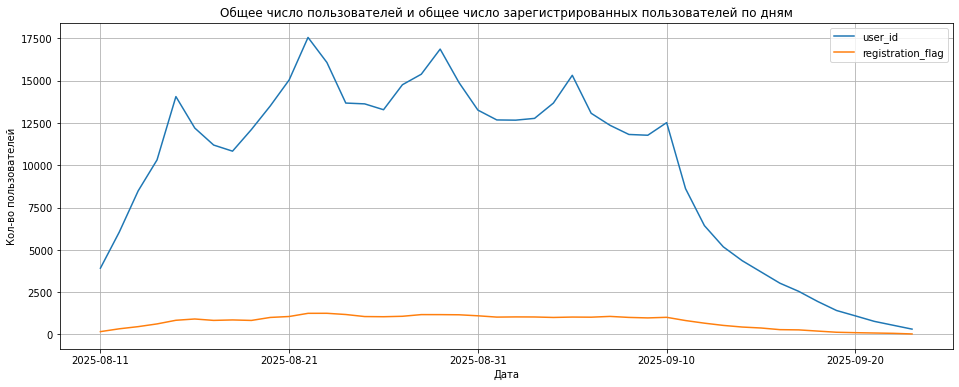

In [7]:
count_users_per_day = sessions_history.groupby('session_date').agg({'user_id':'count',
                                                                    'registration_flag':'sum'}).reset_index()
print(count_users_per_day)
count_users_per_day.plot(kind = 'line',
                        x = 'session_date',
                        y = ['user_id','registration_flag'],
                        figsize =(16,6),
                        xlabel = 'Дата',
                        ylabel = 'Кол-во пользователей',
                        title = 'Общее число пользователей и общее число зарегистрированных пользователей по дням',
                        grid = True)
plt.show()

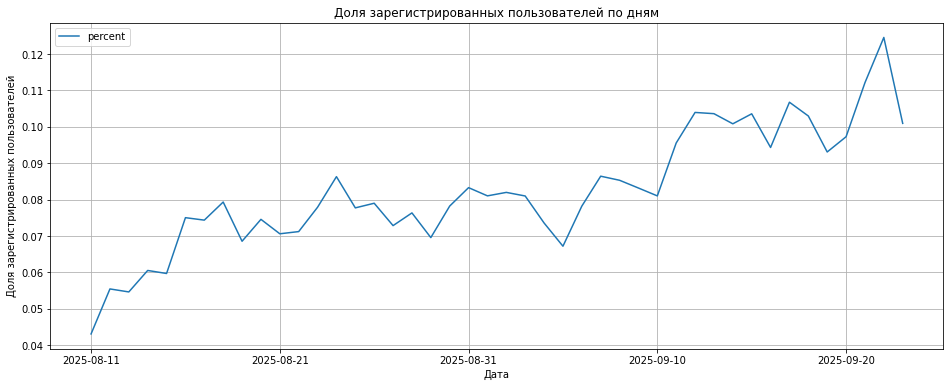

In [8]:
count_users_per_day['percent'] = count_users_per_day['registration_flag']/count_users_per_day['user_id']
count_users_per_day.plot(kind = 'line',
                        x = 'session_date',
                        y = 'percent',
                        figsize =(16,6),
                        xlabel = 'Дата',
                        ylabel = 'Доля зарегистрированных пользователей',
                        title = 'Доля зарегистрированных пользователей по дням',
                        grid = True)
plt.show()

По графику видно, что кол-во зарегистрированных пользоватей растет, но не превышает 20%.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

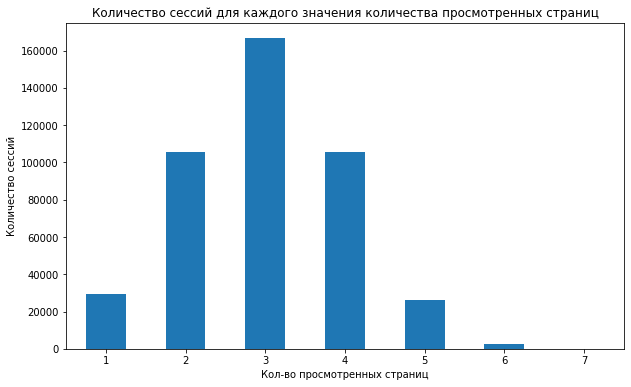

In [9]:
pages_session = sessions_history.groupby('page_counter')['session_id'].count()
pages_session.plot.bar(figsize = (10,6),
                      xlabel = 'Кол-во просмотренных страниц',
                      ylabel = 'Количество сессий',
                      title = 'Количество сессий для каждого значения количества просмотренных страниц')
plt.xticks(rotation=0)
plt.show()

По графику видно, что чаще всего пользователи просматривают 3 страницы, далее идет спад.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [10]:
def good(row):
    if row['page_counter']>=4:
        return 1
    else: 
        return 0
sessions_history['good_session'] = sessions_history.apply(good,axis = 1)

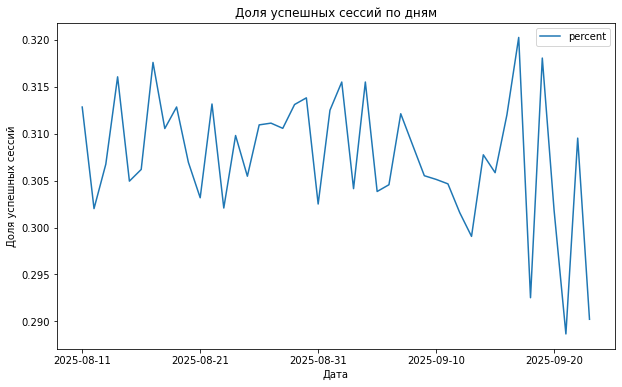

In [11]:
success_sessions = sessions_history.groupby('session_date').agg({'good_session':'sum',
                                                                 'session_id':'count'}).reset_index()
success_sessions['percent'] = success_sessions['good_session']/success_sessions['session_id']
success_sessions.plot(kind = 'line',
                      figsize = (10,6),
                      x = 'session_date',
                      y = 'percent',
                      xlabel = 'Дата',
                      ylabel = 'Доля успешных сессий',
                      title = 'Доля успешных сессий по дням')
plt.show()

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.


- Метрика - доля успешных сессий

- Нулевая гипотеза: Доля успешных сессий не различается.
- Альтернативная гипотеза: Доля успешных сессий стала больше.





#### 2.2. Расчёт размера выборки

In [12]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.1 * p  # Минимальный детектируемый эффект

In [23]:
# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.3. Расчёт длительности A/B-теста

In [14]:
from math import ceil
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

test_group
A    1477
B    1466
Name: user_id, dtype: int64
Процентная разница в количестве пользователей в группах control и test = 0.74%


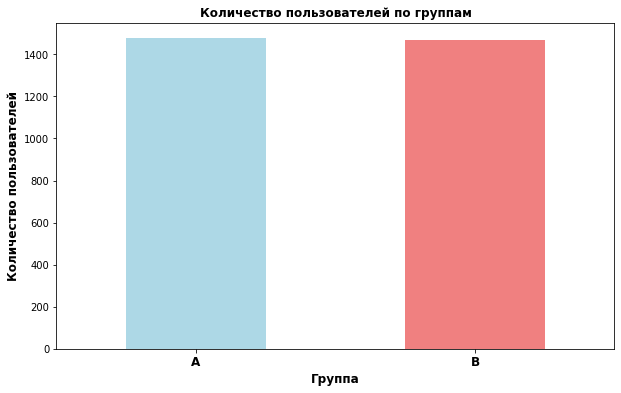

In [15]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
uniq_users = sessions_test_part.groupby('test_group')['user_id'].nunique()
print(uniq_users)
perc_diff = 100*abs(uniq_users[0]-uniq_users[1])/uniq_users[0]
print(f'Процентная разница в количестве пользователей в группах control и test = {perc_diff:.2f}%')
plt.figure(figsize=(10, 6))
uniq_users.plot.bar(color = ['lightblue','lightcoral'])
plt.title('Количество пользователей по группам', fontsize=12, fontweight='bold')
plt.ylabel('Количество пользователей', fontsize=12, fontweight='bold')
plt.xlabel('Группа', fontsize=12, fontweight='bold')
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.show()

#### 3.2. Проверка пересечений пользователей

In [16]:
group_A = sessions_test_part[sessions_test_part['test_group']=='A']
group_B = sessions_test_part[sessions_test_part['test_group']=='B']
c = set(group_A['user_id']).intersection(set(group_B['user_id']))
print('Количество пересечений = ', len(c))

Количество пересечений =  0


#### 3.3. Равномерность разделения пользователей по устройствам

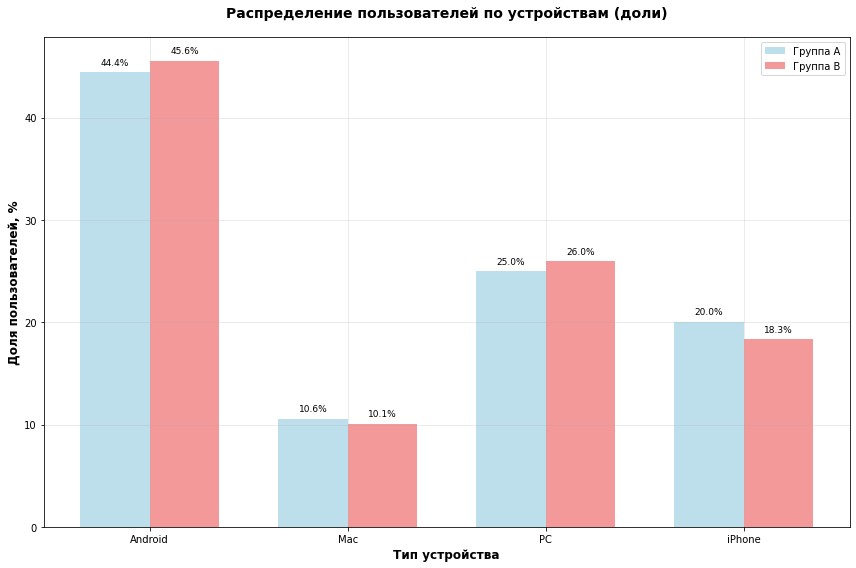

In [17]:
group_A_device = group_A.groupby('device')['user_id'].nunique().reset_index()
group_A_device['share'] = group_A_device['user_id'] / group_A_device['user_id'].sum()

group_B_device = group_B.groupby('device')['user_id'].nunique().reset_index()
group_B_device['share'] = group_B_device['user_id'] / group_B_device['user_id'].sum()

devices = group_A_device['device'].unique()
x_pos = np.arange(len(devices))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x_pos - width/2, group_A_device['share'] * 100, width, 
               label='Группа A', color='lightblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, group_B_device['share'] * 100, width, 
               label='Группа B', color='lightcoral', alpha=0.8)

ax.set_xlabel('Тип устройства', fontsize=12, fontweight='bold')
ax.set_ylabel('Доля пользователей, %', fontsize=12, fontweight='bold')
ax.set_title('Распределение пользователей по устройствам (доли)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(devices)
ax.legend()
ax.grid(True, alpha=0.3)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{bar.get_height():.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам

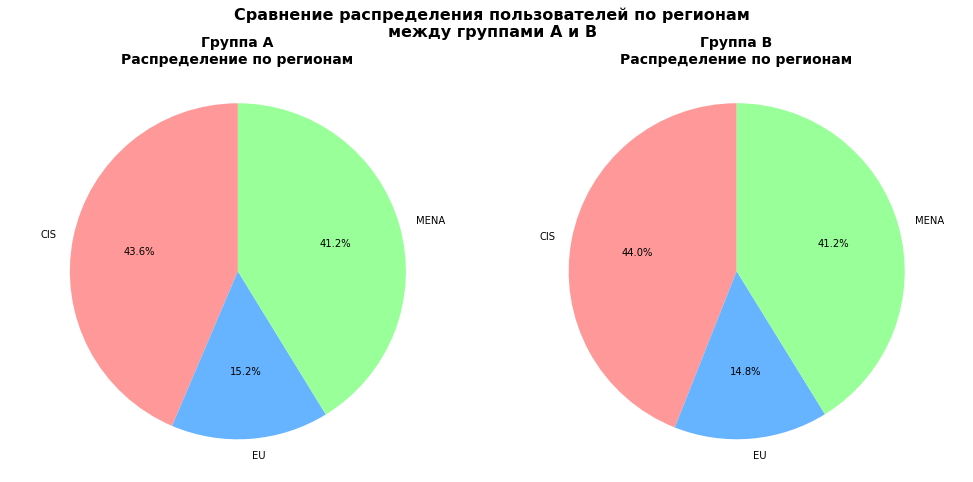

In [18]:
group_A_region = group_A.groupby('region')['user_id'].nunique().reset_index()
group_B_region = group_B.groupby('region')['user_id'].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.pie(group_A_region['user_id'], 
        labels=group_A_region['region'], 
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#cc99ff'],
        startangle=90)
ax1.set_title('Группа A\nРаспределение по регионам', fontsize=14, fontweight='bold')
ax1.axis('equal')
ax2.pie(group_B_region['user_id'], 
        labels=group_B_region['region'], 
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#cc99ff'],
        startangle=90)

ax2.set_title('Группа B\nРаспределение по регионам', fontsize=14, fontweight='bold')
ax2.axis('equal')
plt.suptitle('Сравнение распределения пользователей по регионам\nмежду группами A и B', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста


На основе проведённого анализа A/B-теста не было обнаружено значимых различий в количестве пользователей в двух группах, меньше 1%. Выборки независимые, пользователи из тестовой и контрольной группы не пересекаются. 

Равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам сохраняется. Данные для A/B-теста подходят.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [19]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
def good(row):
    if row['page_counter']>=4:
        return 1
    else: 
        return 0
sessions_test['good_session'] = sessions_test.apply(good,axis = 1)

#### 4.2. Проверка корректности результатов теста

- Метрика - Кол-во сессий(будем работать с session_id)
- Нулевая гипотеза: Кол-во сессий не различается.
- Альтернативная гипотеза: Кол-во сессий различается.

In [20]:
uniq_sessions_A = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].nunique()
uniq_sessions_B = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].nunique()
result = st.ttest_ind(uniq_sessions_A,uniq_sessions_B, alternative ='two-sided')
alpha = 0.05
if result.pvalue>alpha:
    print(f'p-value = {round(result.pvalue, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: создание нового алгоритма рекомендаций не увеличило кол-во сессий')
else:
    print(f'p-value = {round(result.pvalue, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: создание нового алгоритма рекомендаций увеличило кол-во сессий')

p-value = 0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: создание нового алгоритма рекомендаций не увеличило кол-во сессий


#### 4.3. Сравнение доли успешных сессий

In [21]:
all_sessions_a = sessions_test[sessions_test['test_group']=='A']
all_sessions_b = sessions_test[sessions_test['test_group']=='B']
success_a = all_sessions_a[all_sessions_a['good_session']==1]['session_id'].nunique()/all_sessions_a['session_id'].nunique()
success_b = all_sessions_b[all_sessions_b['good_session']==1]['session_id'].nunique()/all_sessions_b['session_id'].nunique()
print(f'Доли успешных сессий: группы А - {round(success_a, 3)}, группы B - {round(success_b, 3)}')
print(f'Разница долей: {round(abs(success_a - success_b)*100,1)}%')

Доли успешных сессий: группы А - 0.308, группы B - 0.318
Разница долей: 1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

- Метрика - доля успешных сессий (будем работать с good_session)
- Нулевая гипотеза: Доля успешных сессий не различается.
- Альтернативная гипотеза: Доля успешных сессий стала больше.

In [22]:
from statsmodels.stats.proportion import proportions_ztest
n_a,n_b = all_sessions_a['session_id'].nunique(),all_sessions_b['session_id'].nunique()
m_a,m_b = all_sessions_a[all_sessions_a['good_session']==1]['session_id'].nunique(),all_sessions_b[all_sessions_b['good_session']==1]['session_id'].nunique()
p_a,p_b = m_a/n_a,m_b/n_b
alpha = 0.05
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha =  0.05


stat_ztest, p_value_ztest = proportions_ztest([m_b, m_a],[n_b, n_a], alternative='larger')

print(f'pvalue={p_value_ztest:.4f}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

text_interpretation = 'увеличилась'

print(f'При создании нового алгоритма рекомендаций, доля успешных сессий {text_interpretation}')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.0002
Нулевая гипотеза не находит подтверждения!
При создании нового алгоритма рекомендаций, доля успешных сессий увеличилась


#### 4.5. Вывод по результатам A/B-эксперимента

Количество задействованных пользователей - 34882 человека и длительность эксперимента - 4 дня.

Внедрение нового алгоритма рекомендаций повлияло на рост ключевой метрики на 1.1%.

p-value = 0.0002.

Внедрить нововведение стоит для всех пользователей. Алгоритм доказал свою эффективность, статистически значимо увеличив долю сессий, в которых пользователи просматривают 4 и более страниц.